### Hopefield network implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Hopfield:
    def __init__(self, nb_neurons, weight_matrix=None):
        self.nb_neurons = nb_neurons
        self.neurons = np.zeros(nb_neurons)
        if weight_matrix is None:
            self.weights = np.zeros((nb_neurons, nb_neurons))
        else:
            self.weights = weight_matrix
    
    def clamp(self, sample):
        assert sample.shape == self.neurons.shape
        self.neurons = sample

    def state(self):
        return self.neurons

    def restart_learning(self):
        self.weights = np.zeros((self.nb_neurons, self.nb_neurons))

    # Warning /!\ keep old values of self.weights
    # If need to restart learning, use restart_learning function
    def hebbian_learning(self, patterns):
        for i in range(self.nb_neurons):
            for j in range(self.nb_neurons):
                if i != j:
                    for p in patterns:
                        self.weights[i][j] += p[i] * p[j]
                    self.weights[i][j] /= self.nb_neurons
    
    def asynchronous_recall(self, pattern, nb_iterations):
        self.clamp(pattern)
        energies = list()
        neurons_to_update = np.random.randint(self.nb_neurons, size=nb_iterations)
        for update in neurons_to_update:
            self.neurons[update] = 1 if self.weights[update] @ self.neurons >= 0 else -1
            energies.append(self.energy(self.state()))
        return energies

    def little_model_recall(self, pattern, nb_iterations):
        self.clamp(pattern)
        
        for x in range(nb_iterations):
            
            prev = self.neurons.copy()
            # for i in range(self.nb_neurons):
            #     self.neurons[i] = 1 if self.weights[i] @ self.neurons >= 0 else -1

            
            self.neurons = np.where(self.weights @ self.neurons >= 0, 1, -1)
            # if (np.all(self.neurons == prev)):
            #     print("Converged after {}".format(x))
            #     break

    def energy(self, p):
        return - p @ self.weights @ p.T


### 3.1 Convergence and attractors

In [3]:
x1 = [-1, -1, 1, -1, 1, -1, -1, 1]
x2 = [-1, -1, -1, -1, -1, 1, -1, -1]
x3 = [-1, 1, 1, -1, -1, 1, -1, 1]

patterns = np.vstack((x1, x2, x3))

In [4]:
dim = patterns.shape[1]

net = Hopfield(dim)

net.hebbian_learning(patterns)

# Test recall patterns
print('Test on learned patterns')
for i, p in enumerate(patterns):
    net.asynchronous_recall(p, 5)
    if np.sum(p != net.state()) != 0:
        print('--> Error!')
        print(f'pattern : {p}')
        print(f'recall : {net.state()}')
        print('-------')
    else:
        print(f'Pattern {i} recalled')
        print(f'pattern : {p}')
        print(f'recall : {net.state()}')
        print('-------')
print()

# Noisy patterns
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1])
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1])
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1])
noisy_patterns = np.vstack((x1d, x2d, x3d))
# Test recall patterns
print('Test on noisy patterns')
for i, p in enumerate(noisy_patterns):
    net.asynchronous_recall(p, 1000)
    if np.sum(patterns[i] != net.state()) != 0:
        print('--> Error!')
        print(f'pattern : {patterns[i]}')
        print(f'recall : {net.state()}')
        print('-------')
    else:
        print(f'Pattern {i} recalled')
print()


Test on learned patterns
Pattern 0 recalled
pattern : [-1 -1  1 -1  1 -1 -1  1]
recall : [-1 -1  1 -1  1 -1 -1  1]
-------
Pattern 1 recalled
pattern : [-1 -1 -1 -1 -1  1 -1 -1]
recall : [-1 -1 -1 -1 -1  1 -1 -1]
-------
Pattern 2 recalled
pattern : [-1  1  1 -1 -1  1 -1  1]
recall : [-1  1  1 -1 -1  1 -1  1]
-------

Test on noisy patterns
Pattern 0 recalled
Pattern 1 recalled
--> Error!
pattern : [-1  1  1 -1 -1  1 -1  1]
recall : [-1 -1  1 -1  1 -1 -1  1]
-------



### 3.2 Sequential update

In [5]:
# Extracting patterns from pict.dat

# Open the file for reading
file_path = "pict.dat"
with open(file_path, "r") as file:
    # Read the entire content of the file
    content = file.read()

patterns = list()
pattern_size = 1024

current_pattern = list()
reading_index = 0
while reading_index < len(content):
    if content[reading_index] == '1':
        current_pattern.append(1)
    elif content[reading_index] == '-':
        current_pattern.append(-1)
        reading_index += 1
    if len(current_pattern) == pattern_size:
        patterns.append(current_pattern)
        current_pattern = list()
    reading_index+=2

patterns = np.array(patterns)
patterns.shape

(11, 1024)

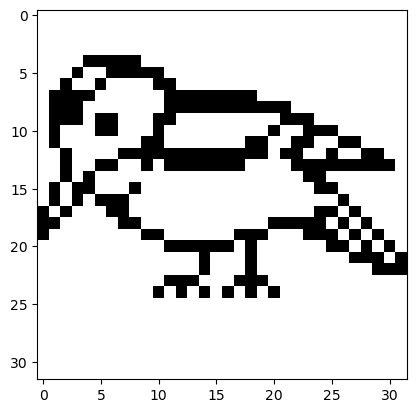

In [6]:
# Look at pattern 6 as an image
p6 = patterns[5]    # index is number - 1 !

image_p6 = p6.reshape((32, 32))
plt.imshow(image_p6, cmap='gray')  # 'cmap' sets the colormap (gray for grayscale)

In [7]:
# Learning the 3 first

dim = patterns.shape[1]

net = Hopfield(dim)

net.hebbian_learning(patterns[:3])

In [8]:
# Test recall 3 first patterns
print('Test on learned patterns')
for i, p in enumerate(patterns[:3]):
    net.asynchronous_recall(p.copy(), 5)
    if np.sum(p != net.state()) != 0:
        print('--> Error!')
        print(f'pattern : {p}')
        print(f'recall : {net.state()}')
        print('-------')
    else:
        print(f'Pattern {i} recalled')

Test on learned patterns
Pattern 0 recalled
Pattern 1 recalled
Pattern 2 recalled


Test on learned patterns
Pattern before recall


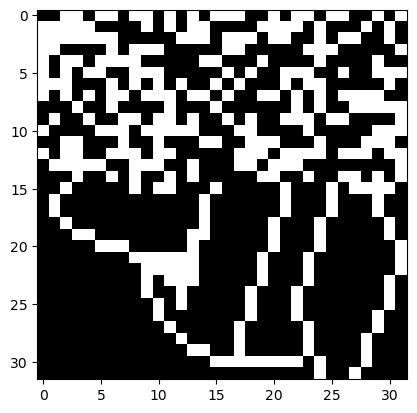

Pattern after asynchronous recall


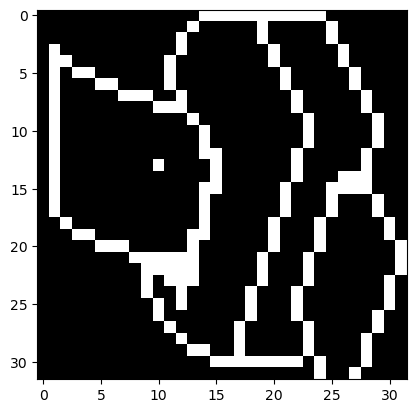

Pattern after little model recall


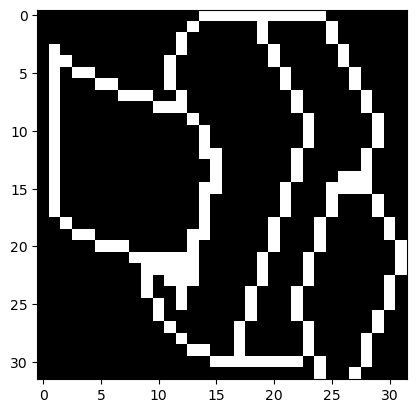

----------------------------------------------------
Pattern before recall


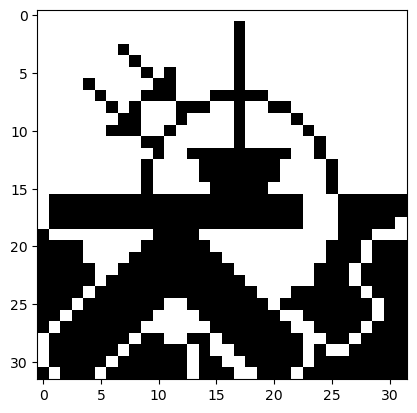

Pattern after asynchronous recall


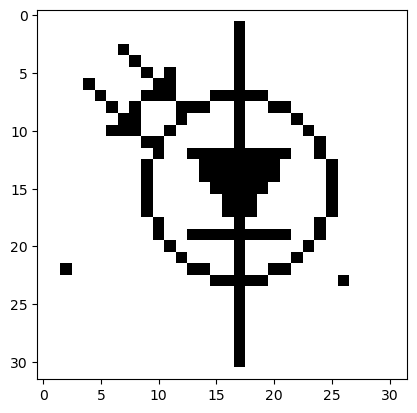

Pattern after little model recall


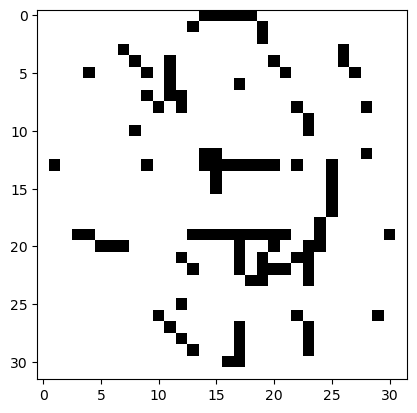

----------------------------------------------------


In [9]:
nb_LM_recall = 5
nb_iter_asynchronous_recall = 32*32*nb_LM_recall

# Test recall on patterns 10 and 11
print('Test on learned patterns')
for i, p in enumerate(patterns[9:]):
    print('Pattern before recall')
    p_reshape = p.reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray') 
    plt.show()

    net.asynchronous_recall(p.copy(), nb_iter_asynchronous_recall)
    print('Pattern after asynchronous recall')
    p_reshape = net.state().reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray')
    plt.show()

    net.little_model_recall(p.copy(), nb_LM_recall)
    print('Pattern after little model recall')
    p_reshape = net.state().reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray')
    plt.show()

    print('----------------------------------------------------')

    

The pattern 11 is recalled into pattern 3 for asynchronous and 2 for synchronous! Does not converge for pattern 10. Global convergence faster? No if we concider than 1 iteration of Little Model is 32*32 iterations of the other model.

### 3.3 Energy

In [10]:
print(net.energy(patterns[0]))
print(net.energy(patterns[1]))
print(net.energy(patterns[2]))

print(net.energy(patterns[10]))


-1436.390625
-1362.640625
-1459.25
-170.5


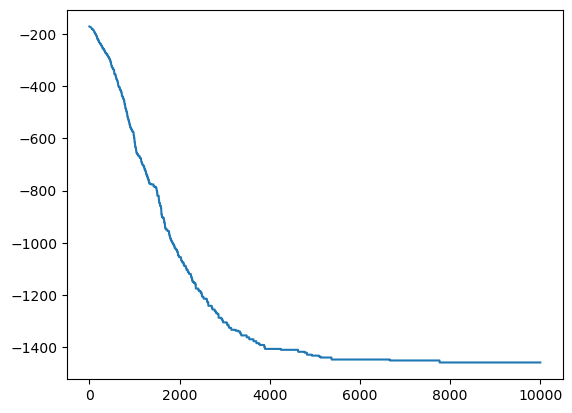

In [11]:
# On pattern 11
energies = net.asynchronous_recall(patterns[10].copy(), 10000)
plt.plot(list(range(len(energies))), energies)

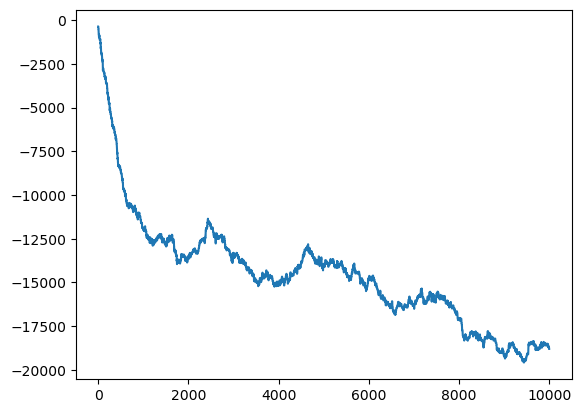

In [12]:
weight_matrix = np.random.randn(1024, 1024)
random_pattern = 2*np.random.randint(2, size=1024) - 1

test_net = Hopfield(1024, weight_matrix=weight_matrix)

# On pattern 11
energies = test_net.asynchronous_recall(random_pattern, 10000)
plt.plot(list(range(len(energies))), energies)

It explores the energy space, trying to find a local minima. As the weights are random, the energy space is chaotic.

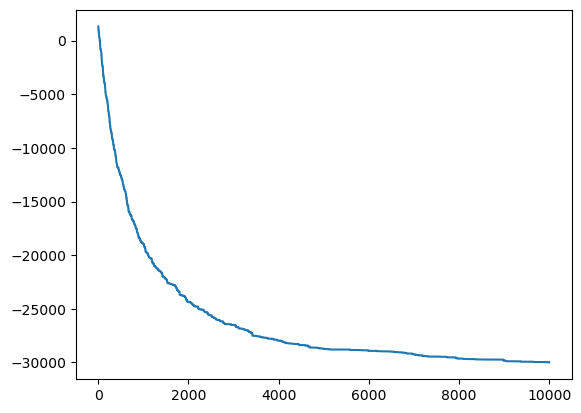

In [13]:
weight_matrix = np.random.randn(1024, 1024)
# Make it symetric
weight_matrix = 0.5 * (weight_matrix + weight_matrix.T)

random_pattern = 2*np.random.randint(2, size=1024) - 1

test_net = Hopfield(1024, weight_matrix=weight_matrix)

# On pattern 11
energies = test_net.asynchronous_recall(random_pattern, 10000)
plt.plot(list(range(len(energies))), energies)

Now the edges of the Hopfield network are bidirectional. Energy landscape is good.

### 3.4 Distorsion Resistance

In [14]:
def plot_pattern(p):
    p_reshape = p.reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray') 
    plt.show()

In [15]:
patterns.shape

(11, 1024)

Noise can be generated as:

In [16]:
noise = np.ones(1024)
noise[:10] = -1
np.random.shuffle(noise)
noise, noise.sum()

(array([1., 1., 1., ..., 1., 1., 1.]), 1004.0)

If I multiply noise with input patterns I flip a randomly a number of bits

Original pattern: 


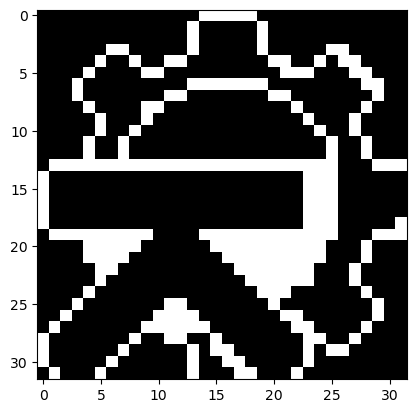

Noise pattern: 


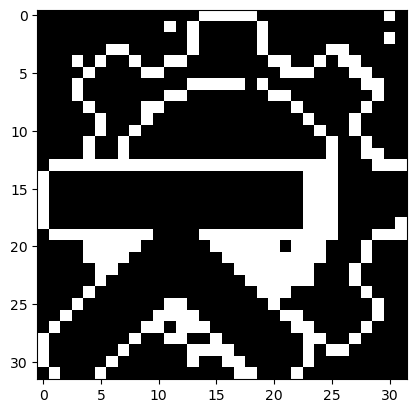

Reconstructed pattern: 


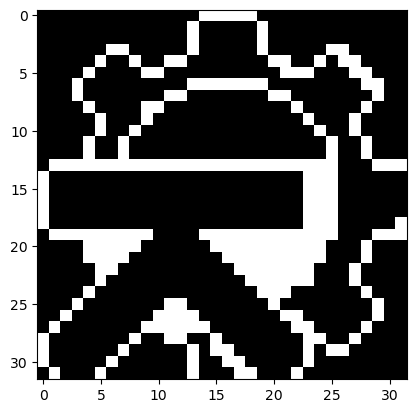

In [17]:
num_pattern = 1
print("Original pattern: ")
plot_pattern(patterns[num_pattern])
print("Noise pattern: ")
noisy_pattern = patterns[num_pattern]*noise
plot_pattern(noisy_pattern)
print("Reconstructed pattern: ")
net.little_model_recall(noisy_pattern.copy(), 1000)
plot_pattern(net.state().reshape((32,32)))

Experimenting with amount of flipped bits:

------Flipping 10.0 percent of the bits--------
Noisy pattern: 


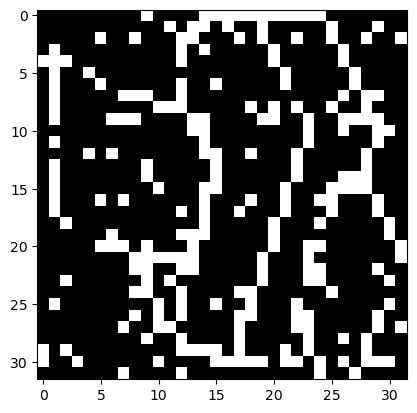

Reconstructed pattern: 


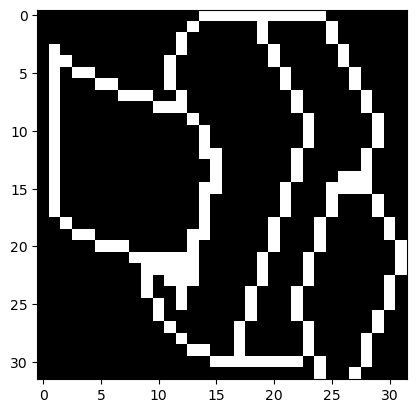

------Flipping 20.0 percent of the bits--------
Noisy pattern: 


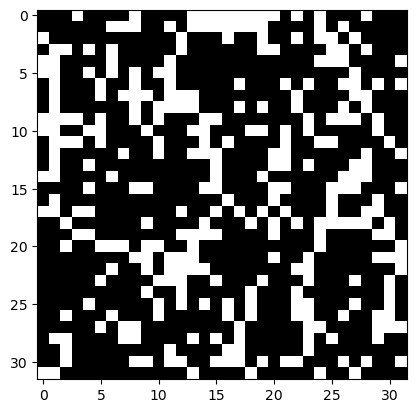

Reconstructed pattern: 


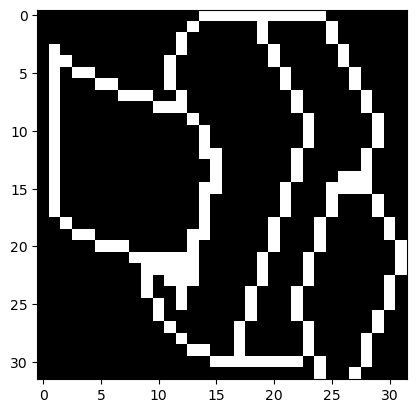

------Flipping 30.0 percent of the bits--------
Noisy pattern: 


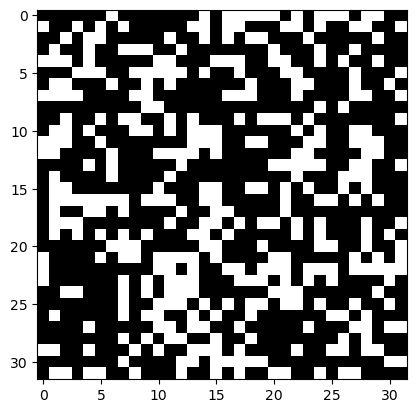

Reconstructed pattern: 


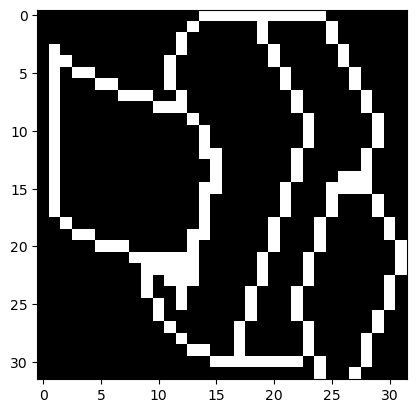

------Flipping 40.0 percent of the bits--------
Noisy pattern: 


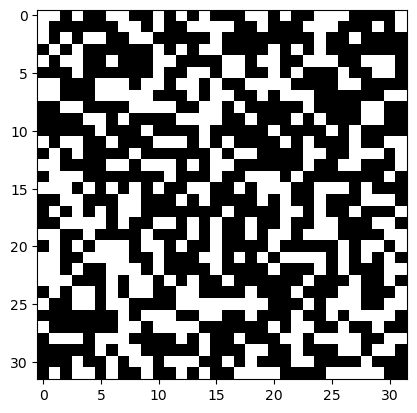

Reconstructed pattern: 


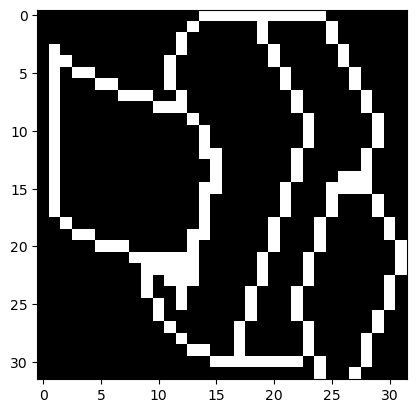

------Flipping 50.0 percent of the bits--------
Noisy pattern: 


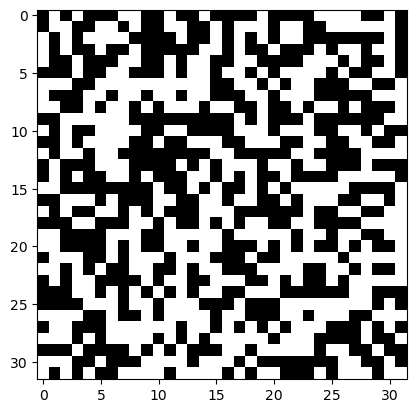

Reconstructed pattern: 


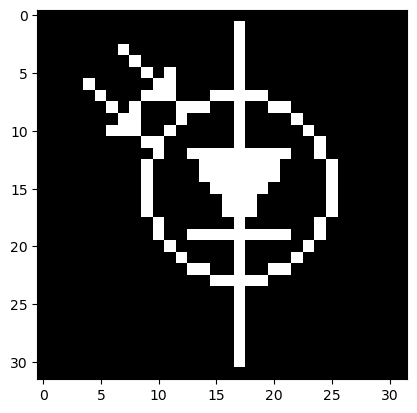

------Flipping 60.0 percent of the bits--------
Noisy pattern: 


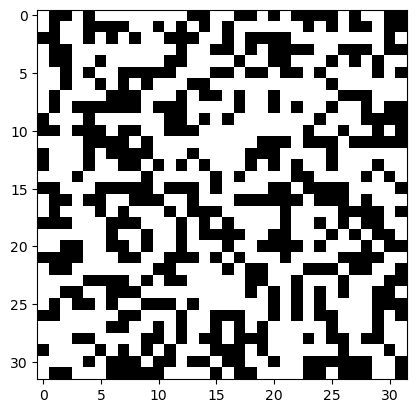

Reconstructed pattern: 


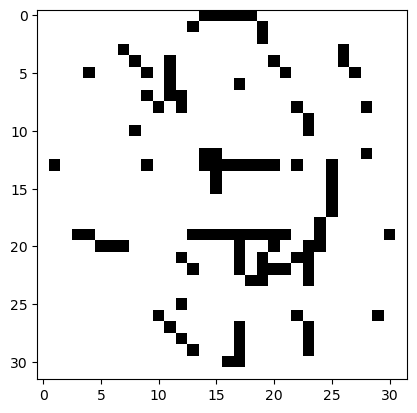

------Flipping 70.0 percent of the bits--------
Noisy pattern: 


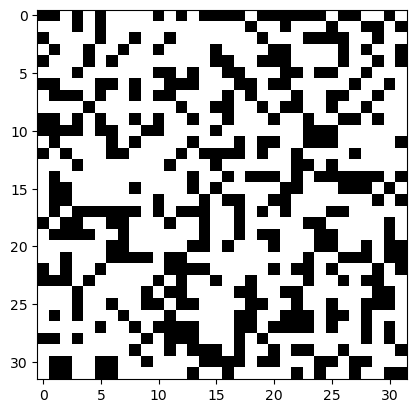

Reconstructed pattern: 


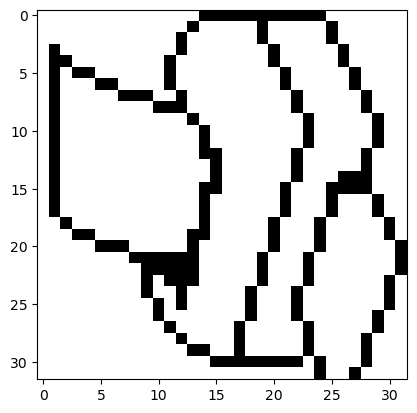

------Flipping 80.0 percent of the bits--------
Noisy pattern: 


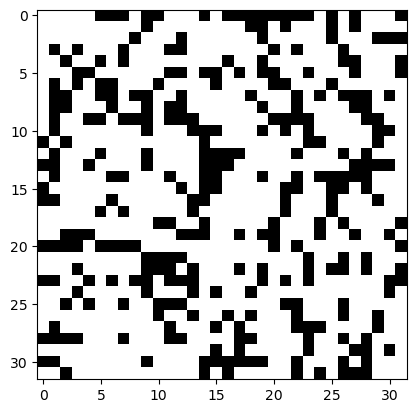

Reconstructed pattern: 


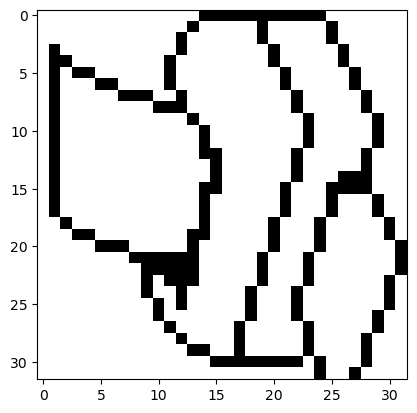

------Flipping 90.0 percent of the bits--------
Noisy pattern: 


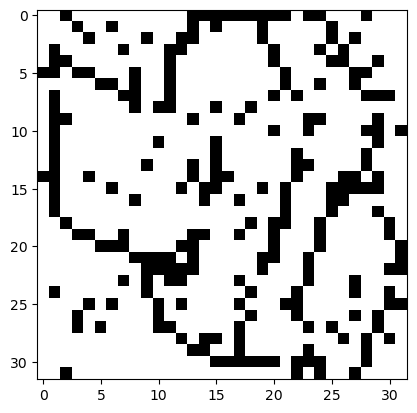

Reconstructed pattern: 


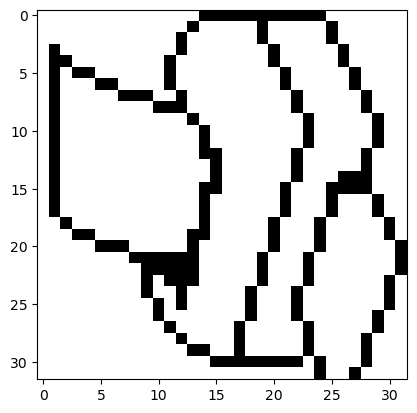

------Flipping 100 percent of the bits--------
Noisy pattern: 


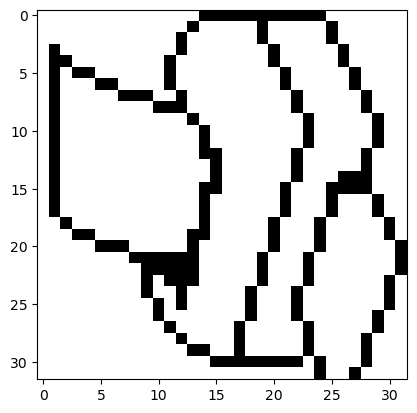

Reconstructed pattern: 


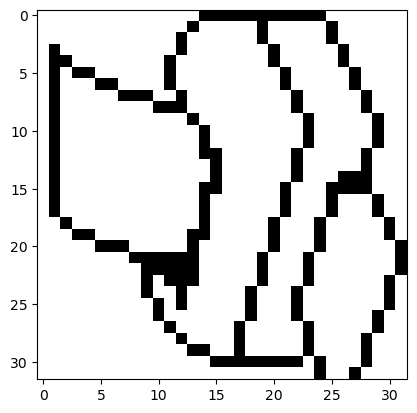

In [18]:
num_pattern = 0
for percent in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:      # from 10% to 100%
    print("------Flipping {} percent of the bits--------".format(percent*100))
    noise = np.ones(1024)
    noise[: int(1024*percent)] = -1
    np.random.shuffle(noise)

    print("Noisy pattern: ")
    noisy_pattern = patterns[num_pattern]*noise
    plot_pattern(noisy_pattern)
    print("Reconstructed pattern: ")
    net.little_model_recall(noisy_pattern, 1000)
    plot_pattern(net.state().reshape((32,32)))

------Flipping 10.0 percent of the bits--------
Noisy pattern: 


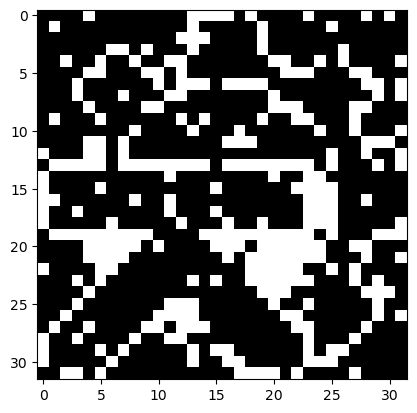

Reconstructed pattern: 


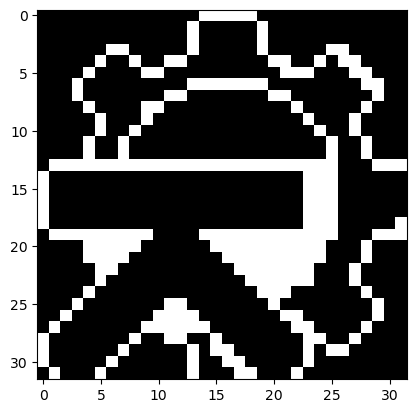

------Flipping 20.0 percent of the bits--------
Noisy pattern: 


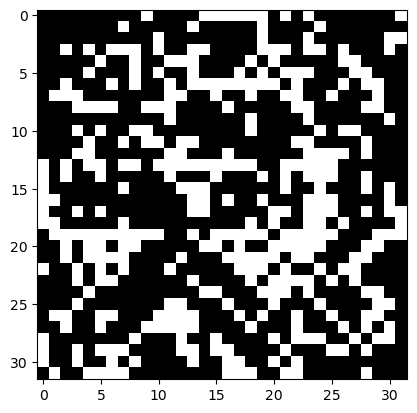

Reconstructed pattern: 


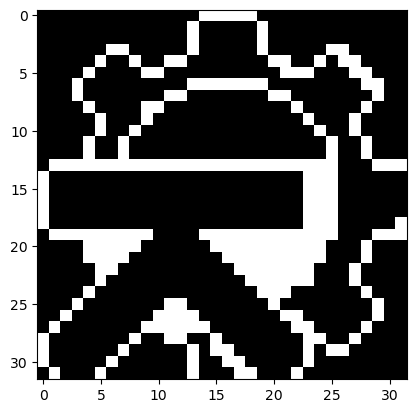

------Flipping 30.0 percent of the bits--------
Noisy pattern: 


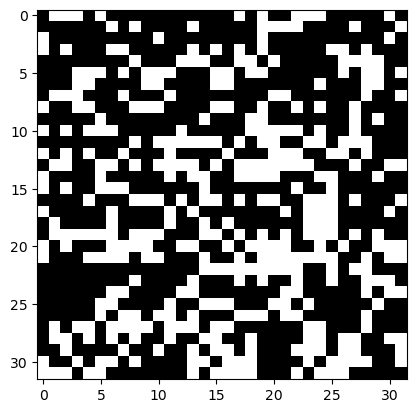

Reconstructed pattern: 


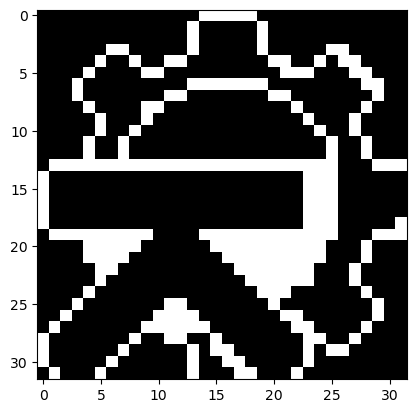

------Flipping 40.0 percent of the bits--------
Noisy pattern: 


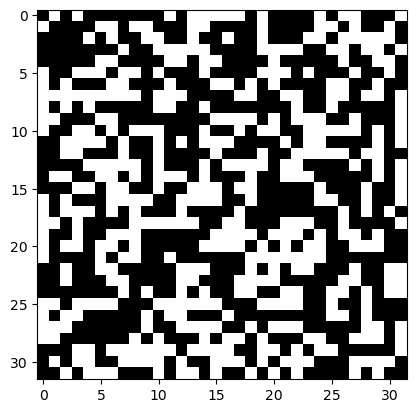

Reconstructed pattern: 


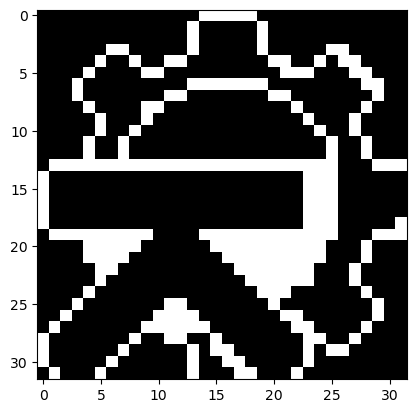

------Flipping 50.0 percent of the bits--------
Noisy pattern: 


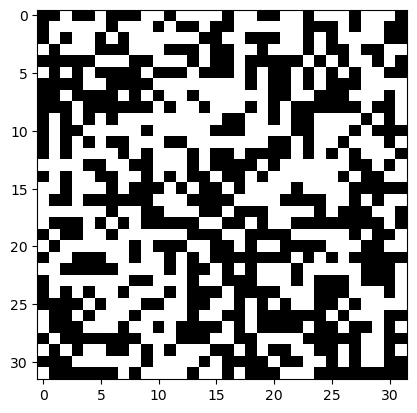

Reconstructed pattern: 


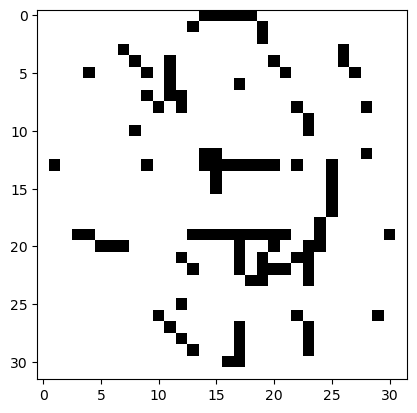

------Flipping 60.0 percent of the bits--------
Noisy pattern: 


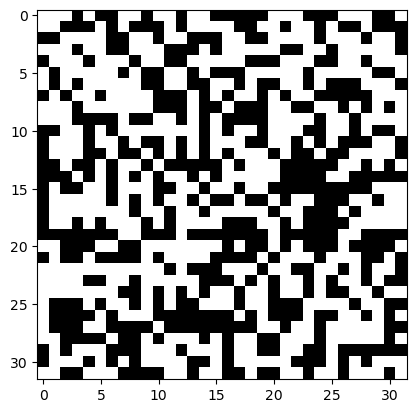

Reconstructed pattern: 


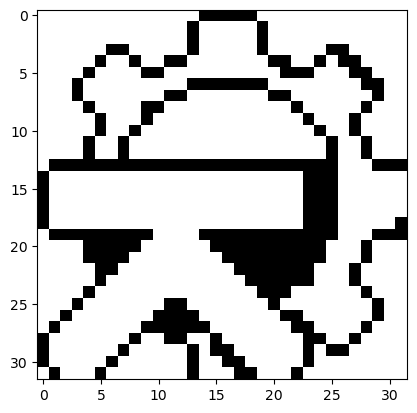

------Flipping 70.0 percent of the bits--------
Noisy pattern: 


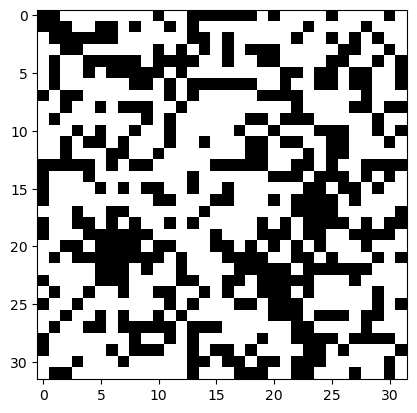

Reconstructed pattern: 


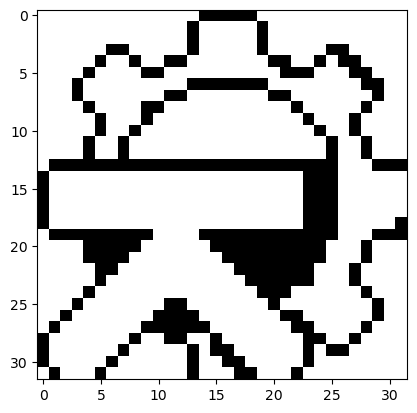

------Flipping 80.0 percent of the bits--------
Noisy pattern: 


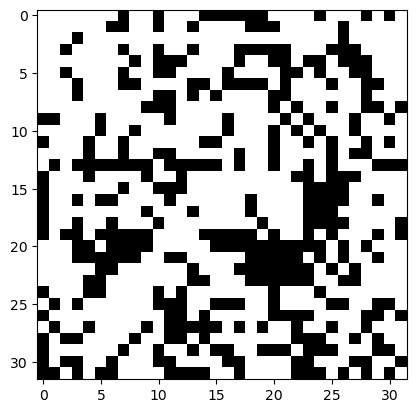

Reconstructed pattern: 


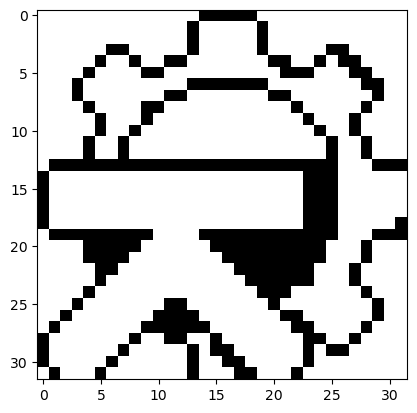

------Flipping 90.0 percent of the bits--------
Noisy pattern: 


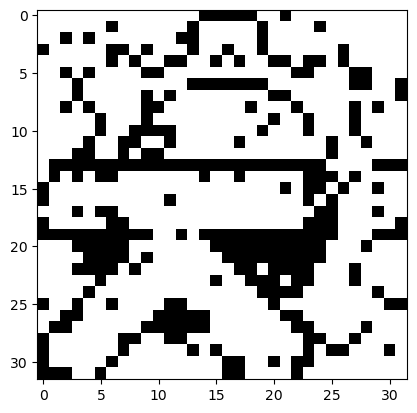

Reconstructed pattern: 


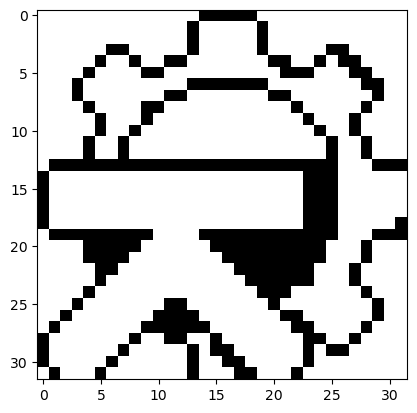

------Flipping 100 percent of the bits--------
Noisy pattern: 


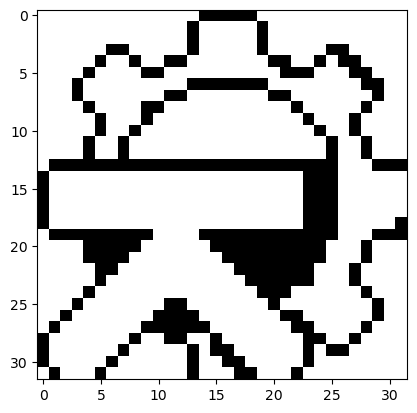

Reconstructed pattern: 


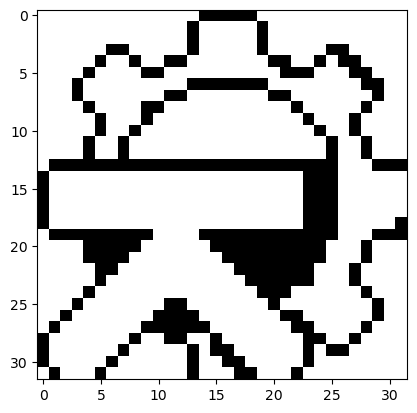

In [19]:
num_pattern = 1
for percent in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:      # from 10% to 100%
    print("------Flipping {} percent of the bits--------".format(percent*100))
    noise = np.ones(1024)
    noise[: int(1024*percent)] = -1
    np.random.shuffle(noise)

    print("Noisy pattern: ")
    noisy_pattern = patterns[num_pattern]*noise
    plot_pattern(noisy_pattern)
    print("Reconstructed pattern: ")
    net.little_model_recall(noisy_pattern, 1000)
    plot_pattern(net.state().reshape((32,32)))

------Flipping 10.0 percent of the bits--------
Noisy pattern: 


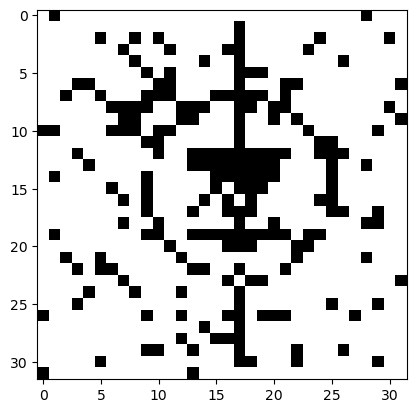

Reconstructed pattern: 


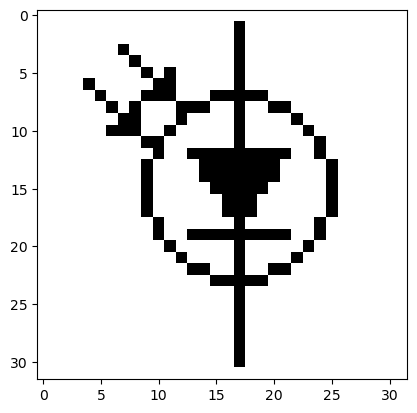

------Flipping 20.0 percent of the bits--------
Noisy pattern: 


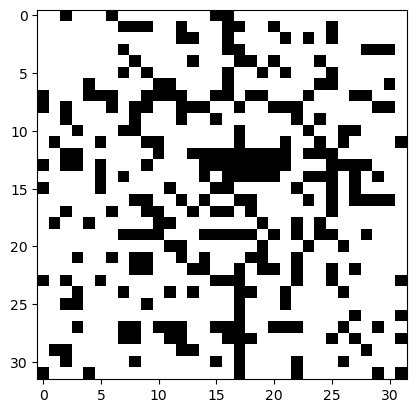

Reconstructed pattern: 


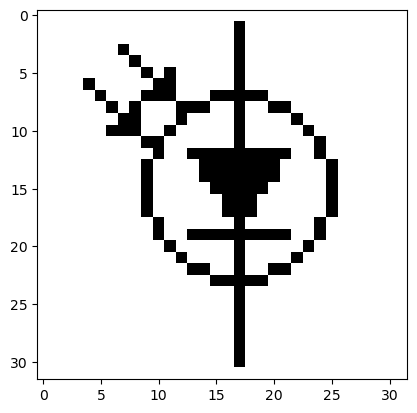

------Flipping 30.0 percent of the bits--------
Noisy pattern: 


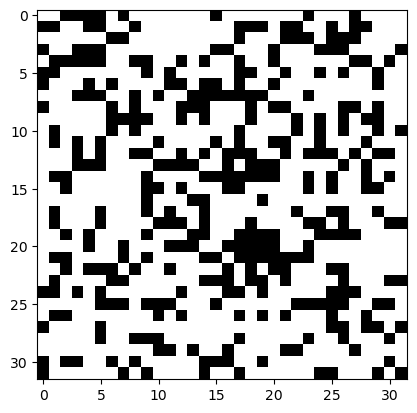

Reconstructed pattern: 


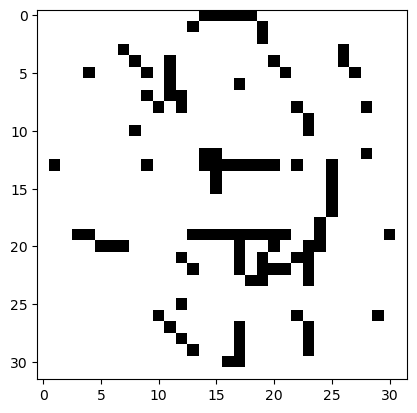

------Flipping 40.0 percent of the bits--------
Noisy pattern: 


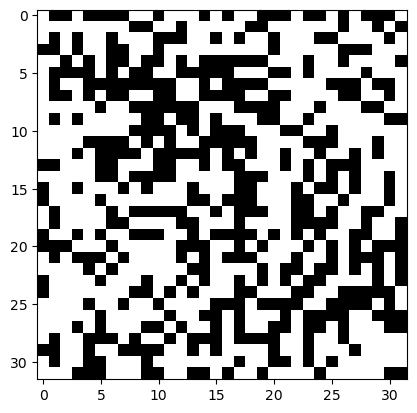

Reconstructed pattern: 


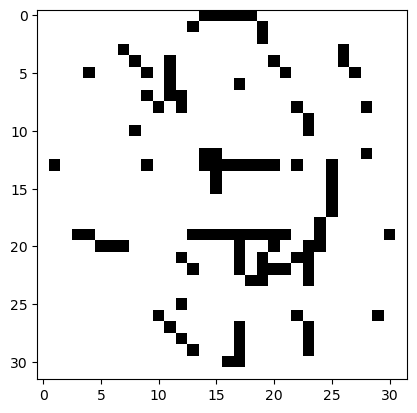

------Flipping 50.0 percent of the bits--------
Noisy pattern: 


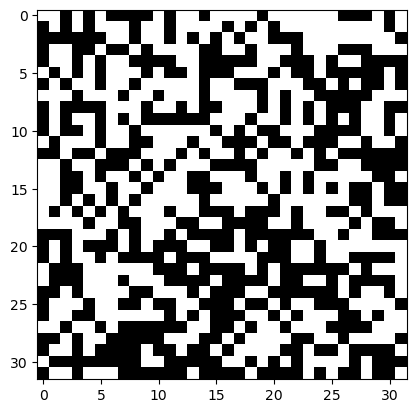

Reconstructed pattern: 


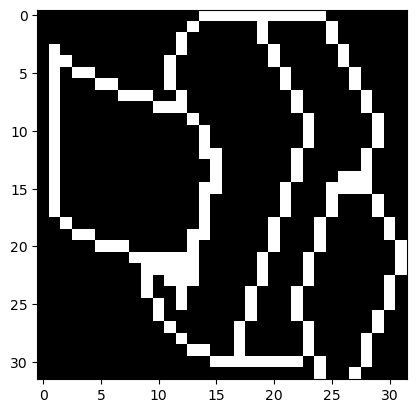

------Flipping 60.0 percent of the bits--------
Noisy pattern: 


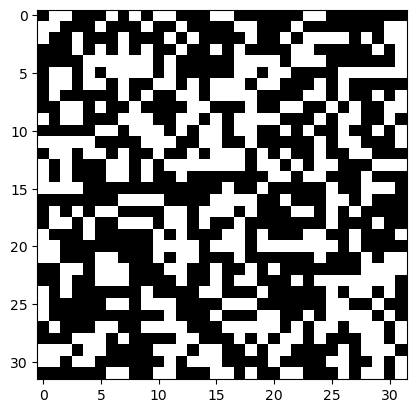

Reconstructed pattern: 


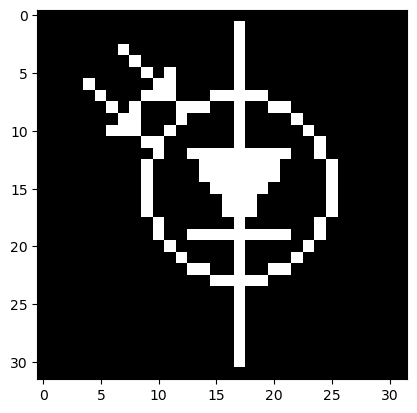

------Flipping 70.0 percent of the bits--------
Noisy pattern: 


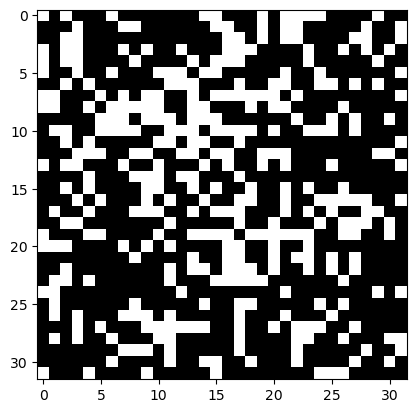

Reconstructed pattern: 


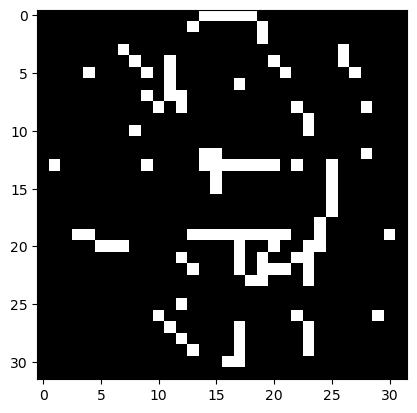

------Flipping 80.0 percent of the bits--------
Noisy pattern: 


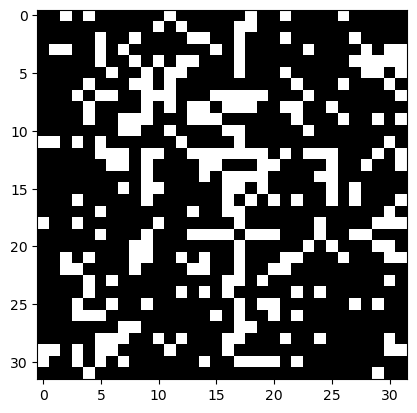

Reconstructed pattern: 


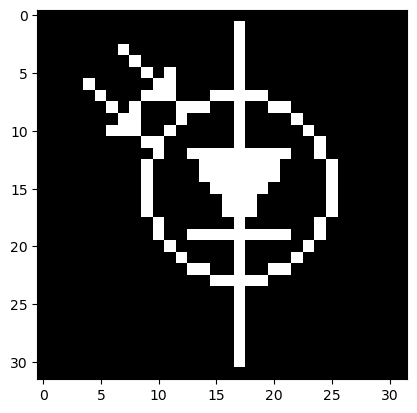

------Flipping 90.0 percent of the bits--------
Noisy pattern: 


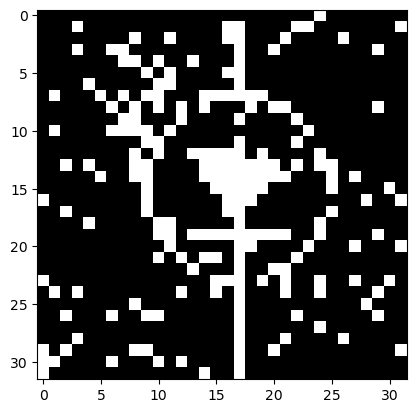

Reconstructed pattern: 


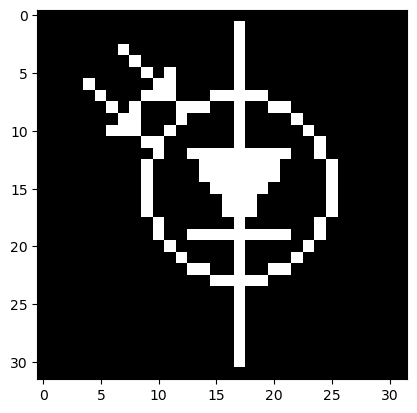

------Flipping 100 percent of the bits--------
Noisy pattern: 


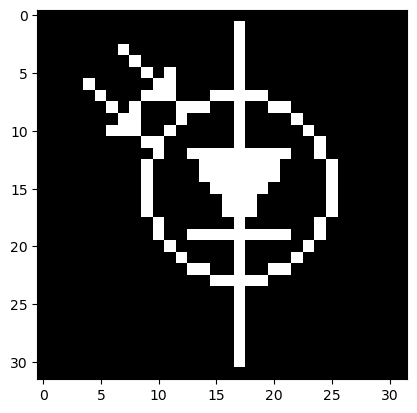

Reconstructed pattern: 


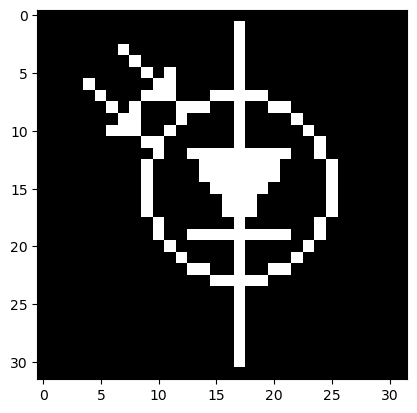

In [20]:
num_pattern = 2
for percent in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:      # from 10% to 100%
    print("------Flipping {} percent of the bits--------".format(percent*100))
    noise = np.ones(1024)
    noise[: int(1024*percent)] = -1
    np.random.shuffle(noise)

    print("Noisy pattern: ")
    noisy_pattern = patterns[num_pattern]*noise
    plot_pattern(noisy_pattern)
    print("Reconstructed pattern: ")
    net.little_model_recall(noisy_pattern, 1000)
    plot_pattern(net.state().reshape((32,32)))

--RESULTS--
Pattern 3 is less noise-resistant than the other two

### 3.5 Capacity

In [21]:
net2 = Hopfield(1024)

num_patterns_learned = 4
net2.hebbian_learning(patterns[:num_patterns_learned])
print(patterns[:num_patterns_learned])

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]]


Has hopnet learnt all 4 patterns?

In [22]:
# a bit of noise
noise = np.ones(1024)
noise[:10] = -1
np.random.shuffle(noise)
noise, noise.sum()

(array([1., 1., 1., ..., 1., 1., 1.]), 1004.0)

Original pattern: 


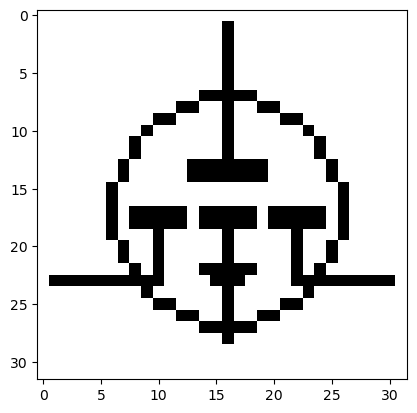

Noise pattern: 


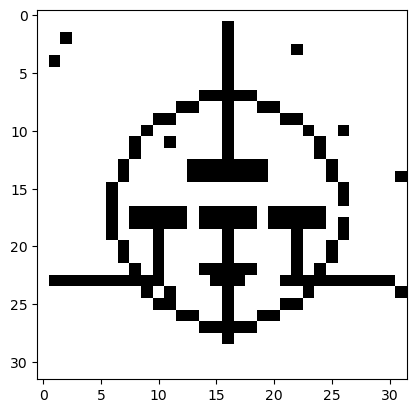

Reconstructed pattern: 


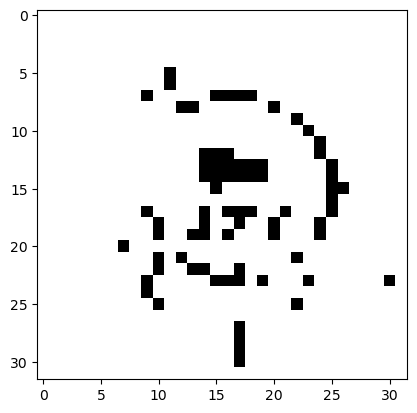

In [23]:
num_pattern = 3         # try between 0 and num_patterns_learned - 1
print("Original pattern: ")
plot_pattern(patterns[num_pattern])
print("Noise pattern: ")
noisy_pattern = patterns[num_pattern]*noise
plot_pattern(noisy_pattern)
print("Reconstructed pattern: ")
net2.little_model_recall(noisy_pattern.copy(), 30)
plot_pattern(net2.state().reshape((32,32)))

Exp: not that good even with 4...

#### Trying with random patterns

In [24]:
p1 = np.random.choice([-1, 1], size=1024)
p2 = np.random.choice([-1, 1], size=1024)
p3 = np.random.choice([-1, 1], size=1024)
p4 = np.random.choice([-1, 1], size=1024)
p5 = np.random.choice([-1, 1], size=1024)

patterns_random = np.vstack((p1,p2,p3,p4,p5))
patterns_random

array([[ 1, -1, -1, ...,  1, -1, -1],
       [-1,  1,  1, ..., -1, -1, -1],
       [ 1,  1,  1, ..., -1,  1, -1],
       [ 1,  1,  1, ...,  1,  1, -1],
       [ 1, -1, -1, ..., -1,  1, -1]])

In [25]:
net3 = Hopfield(1024)

num_patterns_learned = 2
net3.hebbian_learning(patterns_random[:num_patterns_learned])

Original pattern: 


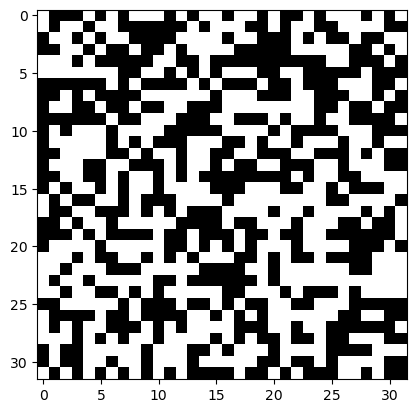

Reconstructed pattern: 


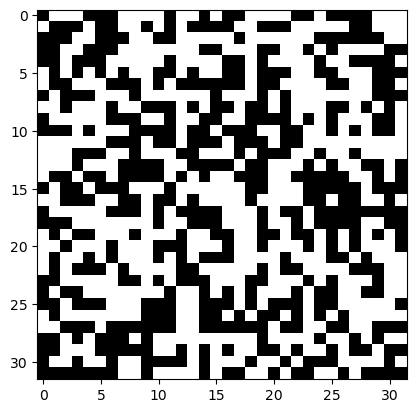

498

In [26]:
num_pattern = 0
print("Original pattern: ")
plot_pattern(patterns_random[num_pattern])
print("Reconstructed pattern: ")
net3.little_model_recall(noisy_pattern.copy(), 30)
plot_pattern(net3.state().reshape((32,32)))

np.sum(net3.state() - patterns_random[num_pattern] != 0)

Exp: even with just two patterns the network isn't able to reconstruct.. This is because of crosstalk I'd say

#### Create 300 random patterns and train a 100-unit (or larger) network with them.
After each new pattern has been added to the weight matrix, calculate
how many of the earlier patterns remain stable (a single iteration does not cause
them to change) and plot it.

In [27]:
random_patterns = np.random.choice([-1, 1], size=(300, 100))
random_patterns.shape

(300, 100)

In [28]:
random_patterns[0,:]

array([-1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
       -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,
       -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1])

In [34]:
random_net = Hopfield(100)

In [35]:
percentages_learnt_patterns = []

for learnt in range(random_patterns.shape[0]):
    random_net.hebbian_learning(random_patterns[learnt:learnt+1])

    attractors_count = 0
    for j in range(0, learnt+1):
        original = random_patterns[j].copy()
        random_net.little_model_recall(original, 1)
        reconstruction = random_net.neurons.copy()

        
        if (np.all(original == reconstruction)):
            print("correct")
            attractors_count += 1
        else:
            print("noo")

    print("learnt {}, tested on {}: {}".format(learnt+1, j, attractors_count))
    percentages_learnt_patterns.append(attractors_count / (learnt+1))

correct
learnt 1, tested on 0: 1
noo
correct
learnt 2, tested on 1: 1
noo
noo
correct
learnt 3, tested on 2: 1
noo
noo
noo
correct
learnt 4, tested on 3: 1
noo
noo
noo
noo
correct
learnt 5, tested on 4: 1
noo
noo
noo
noo
noo
correct
learnt 6, tested on 5: 1
noo
noo
noo
noo
noo
noo
correct
learnt 7, tested on 6: 1
noo
noo
noo
noo
noo
noo
noo
correct
learnt 8, tested on 7: 1
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 9, tested on 8: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 10, tested on 9: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 11, tested on 10: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 12, tested on 11: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 13, tested on 12: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 14, tested on 13: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt 15, tested on 14: 1
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
noo
correct
learnt

In [38]:
random_net.hebbian_learning(random_patterns[learnt:learnt+1])
random_net.weights

array([[ 0.        , -0.01010101, -0.01010099, ...,  0.01010101,
        -0.01010099,  0.01010101],
       [-0.01010101,  0.        ,  0.01010099, ..., -0.01010101,
         0.01010099, -0.01010101],
       [-0.01010099,  0.01010099,  0.        , ..., -0.01010099,
         0.01010101, -0.01010099],
       ...,
       [ 0.01010101, -0.01010101, -0.01010099, ...,  0.        ,
        -0.01010099,  0.01010101],
       [-0.01010099,  0.01010099,  0.01010101, ..., -0.01010099,
         0.        , -0.01010099],
       [ 0.01010101, -0.01010101, -0.01010099, ...,  0.01010101,
        -0.01010099,  0.        ]])